In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Bidirectional, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Input, regularizers, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber



In [2]:

sys.path.append(r'c:\Users\Hanss\Documents\Data Science Project\predictive-maintenance\src\Data processing scripts')


In [3]:
from CSV_module import CSVReader
from PreProcess_module import PreProcessor
from SQL_module import SQLManager  
from Logging_module import LoggerSetup

In [4]:
# Define the folder path where the CSV files are stored
folder_path = r'C:\Users\Hanss\Documents\Data Science Project\predictive-maintenance\data\raw'



# Initialize the CSVReader with the local folder path
csv_reader = CSVReader(folder_path, 'files_read_log.txt', 'csv_reader.log')

# Read the files from the specified folder
dataframes = csv_reader.read_files_from_folder()


df1 = dataframes['df_errors']
df2 = dataframes['df_failures']
df3 = dataframes['df_machines']
df4 = dataframes['df_maint']
df5 = dataframes['df_telemetry']






In [5]:
for df in [df1, df2, df4, df5]:
    df['datetime'] = pd.to_datetime(df['datetime'])

df5_2015 = df5[(df5['datetime'] >= '2015-01-01') & (df5['datetime'] < '2016-01-01')]
df2_2015 = df2[(df2['datetime'] >= '2015-01-01') & (df2['datetime'] < '2016-01-01')]
df1_2015 = df1[(df1['datetime'] >= '2015-01-01') & (df1['datetime'] < '2016-01-01')]
df4_2015 = df4[(df4['datetime'] >= '2015-01-01') & (df4['datetime'] < '2016-01-01')]

# Create onehot encoding for failure and merge with telemetry information.
df_fail = pd.get_dummies(df2_2015, columns=['failure'], dtype=int, prefix='fail').groupby(['datetime', 'machineID']).sum().reset_index()
df_fail['failure_indicator'] = 1

df_merged = pd.merge(
    df5_2015,
    df_fail[['machineID', 'datetime', 'fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4', 'failure_indicator']],
    on=['machineID', 'datetime'],
    how='left'
)
df_merged.fillna({'failure_indicator': 0, 'fail_comp1': 0, 'fail_comp2': 0, 'fail_comp3': 0, 'fail_comp4': 0}, inplace=True)
df_merged[['failure_indicator', 'fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4']] = df_merged[
    ['failure_indicator', 'fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4']
].astype(int)

# Create onehot encoding for errors and merge.
df_error = pd.get_dummies(df1_2015, columns=['errorID'], dtype=int, prefix='').groupby(['datetime', 'machineID']).sum().reset_index()
df_error['error_indicator'] = 1

df_merged = pd.merge(
    df_merged,
    df_error[['machineID', 'datetime', '_error1', '_error2', '_error3', '_error4', '_error5', 'error_indicator']],
    on=['machineID', 'datetime'],
    how='left'
)
df_merged.fillna({'error_indicator': 0, '_error1': 0, '_error2': 0, '_error3': 0, '_error4': 0, '_error5': 0}, inplace=True)

# Calculate time since last errorr. Nans handled separately. 
df_merged['datetime_error'] = df_merged['datetime'].where(df_merged['error_indicator'] == 1)
df_merged['datetime_error'] = df_merged.groupby('machineID')['datetime_error'].bfill()
df_merged['time_since_last_error'] = (df_merged['datetime_error'] - df_merged['datetime']).dt.total_seconds() / 3600

# Create onehot encoding for maintenance and merge.
df_main = pd.get_dummies(df4_2015, columns=['comp'], dtype=int, prefix='maint').groupby(['datetime', 'machineID']).sum().reset_index()
df_main['maint_indicator'] = 1

df_merged = pd.merge(
    df_merged,
    df_main[['machineID', 'datetime', 'maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4', 'maint_indicator']],
    on=['machineID', 'datetime'],
    how='left'
)
df_merged.fillna({'maint_indicator': 0, 'maint_comp1': 0, 'maint_comp2': 0, 'maint_comp3': 0, 'maint_comp4': 0}, inplace=True)

# Calculate time since last maintenace and merge. Nans handled separately. 
df_merged['datetime_maint'] = df_merged['datetime'].where(df_merged['maint_indicator'] == 1)
df_merged['datetime_maint'] = df_merged.groupby('machineID')['datetime_maint'].bfill()
df_merged['time_since_last_maint'] = (df_merged['datetime_maint'] - df_merged['datetime']).dt.total_seconds() / 3600

# Adding information on machines age and model type.
df_machine = pd.get_dummies(df3, columns=['model'], dtype=int, prefix='').groupby(['machineID']).sum().reset_index()
df_merged = pd.merge(df_merged, df_machine, on=['machineID'], how='left')

df_merged.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4',
       'failure_indicator', '_error1', '_error2', '_error3', '_error4',
       '_error5', 'error_indicator', 'datetime_error', 'time_since_last_error',
       'maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4',
       'maint_indicator', 'datetime_maint', 'time_since_last_maint', 'age',
       '_model1', '_model2', '_model3', '_model4'],
      dtype='object')

No failures found for machineID 6, using average RUL for adjustments.
No failures found for machineID 77, using average RUL for adjustments.


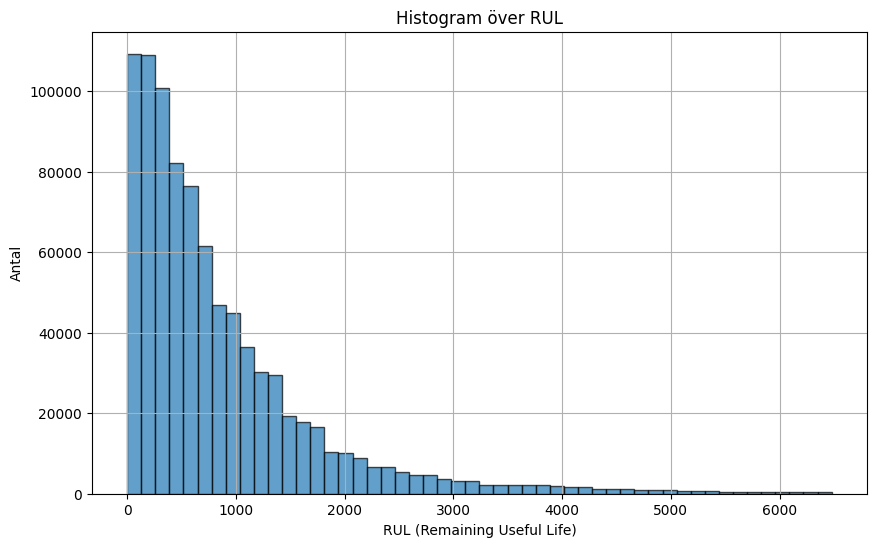

In [6]:
# Calculate datetime of next failure for each row where failure_indicator is 1
df_merged['datetime_failure'] = df_merged['datetime'].where(df_merged['failure_indicator'] == 1)
df_merged['datetime_failure'] = df_merged.groupby('machineID')['datetime_failure'].bfill()

# Calculate RUL as the time difference in hours
df_merged['RUL'] = (df_merged['datetime_failure'] - df_merged['datetime']).dt.total_seconds() / 3600

# Calculate mean RUL per machine
machine_rul_means = df_merged.groupby('machineID')['RUL'].mean().to_dict()

# Adjust NaN RULs for each machine using mean values
for machine_id, mean_rul in machine_rul_means.items():
    machine_data = df_merged[df_merged['machineID'] == machine_id].copy()

    # Find the index of the last known failure for this machine
    last_fail_index = machine_data[machine_data['failure_indicator'] == 1].index.max()

    if pd.isna(last_fail_index):
        print(f"No failures found for machineID {machine_id}, using average RUL for adjustments.")
        # Use the mean RUL for the entire machine if no failure is present
        mean_value = mean_rul
        initial_mean_value = mean_value
        nan_indices = machine_data.index

        for index in nan_indices:
            df_merged.loc[index, 'RUL'] = max(mean_value, 0)
            mean_value -= 1
            if mean_value < 0:
                mean_value = initial_mean_value
    else:
        # Use mean RUL for NaN values after the last failure
        mean_value = mean_rul
        initial_mean_value = mean_value
        nan_indices_after_failure = machine_data.loc[last_fail_index + 1:, 'RUL'].index

        for index in nan_indices_after_failure:
            df_merged.loc[index, 'RUL'] = max(mean_value, 0)
            mean_value -= 1
            if mean_value < 0:
                mean_value = initial_mean_value

# Handle machines similar to machine 77
# Find similar machines (age 10-15 years and model 4)
model4_machines_like_77 = df3[(df3['model'] == 'model4') & (df3['age'] >= 10) & (df3['age'] <= 15)]
model4_machines_like_77_list = model4_machines_like_77['machineID']
model4_machines_like_77_data = df_merged[df_merged['machineID'].isin(model4_machines_like_77_list)]
model4_machines_like_77_data = model4_machines_like_77_data.dropna(subset=['RUL'])
mean_rul_model4_like_77 = model4_machines_like_77_data['RUL'].mean()

# Apply the calculated average RUL to machine 77 and count down
machine_data_77 = df_merged[df_merged['machineID'] == 77].copy()
mean_value_77 = mean_rul_model4_like_77
initial_mean_value_77 = mean_value_77

nan_indices_after_failure_77 = machine_data_77.index[machine_data_77['RUL'].isna()]

for index in nan_indices_after_failure_77:
    df_merged.loc[index, 'RUL'] = max(mean_value_77, 0)
    mean_value_77 -= 1
    if mean_value_77 < 0:
        mean_value_77 = initial_mean_value_77

# Handle machines similar to machine 6
# Find similar machines (age 7 and model 3)
machine_like_6 = df3[(df3['model'] == 'model3') & (df3['age'] == 7)]['machineID']
machine_like_6_data = df_merged[df_merged['machineID'].isin(machine_like_6)]
mean_rul_machine_like_6 = machine_like_6_data['RUL'].mean()

# Apply the calculated average RUL to machine 6 and count down
machine_data_6 = df_merged[df_merged['machineID'] == 6].copy()
mean_value_6 = mean_rul_machine_like_6
initial_mean_value_6 = mean_value_6

nan_indices_6 = machine_data_6.index[machine_data_6['RUL'].isna()]

for index in nan_indices_6:
    df_merged.loc[index, 'RUL'] = max(mean_value_6, 0)
    mean_value_6 -= 1
    if mean_value_6 < 0:
        mean_value_6 = initial_mean_value_6


# Visulaize distribution
plt.figure(figsize=(10, 6))
plt.hist(df_merged['RUL'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram över RUL')
plt.xlabel('RUL (Remaining Useful Life)')
plt.ylabel('Antal')
plt.grid(True)
plt.show()


In [7]:
df_merged['RUL'].isna().sum()

np.int64(0)

In [8]:
error_means = df_merged.groupby('machineID')['time_since_last_error'].mean().to_dict()

# Adjust NaN time_since_last_error values for each machine using mean values
for machine_id, mean_error in error_means.items():
    machine_data = df_merged[df_merged['machineID'] == machine_id].copy()

    # Find the index of the last known error for this machine
    last_error_index = machine_data[machine_data['error_indicator'] == 1].index.max()

    if pd.isna(last_error_index):
        print(f"No errors found for machineID {machine_id}, using average time since last error for adjustments.")
        # Use the mean time since last error for the entire machine if no error is present
        mean_value = mean_error
        initial_mean_value = mean_value
        nan_indices = machine_data.index

        for index in nan_indices:
            df_merged.loc[index, 'time_since_last_error'] = max(mean_value, 0)
            mean_value -= 1
            if mean_value < 0:
                mean_value = initial_mean_value
    else:
        # Use mean time since last error for NaN values after the last error
        mean_value = mean_error
        initial_mean_value = mean_value
        nan_indices_after_error = machine_data.loc[last_error_index + 1:, 'time_since_last_error'].index

        for index in nan_indices_after_error:
            df_merged.loc[index, 'time_since_last_error'] = max(mean_value, 0)
            mean_value -= 1
            if mean_value < 0:
                mean_value = initial_mean_value

In [9]:
df_merged['time_since_last_error'].isna().sum()

np.int64(0)

In [10]:
# Calculate mean time since last maintenance for each machine
maintenance_means = df_merged.groupby('machineID')['time_since_last_maint'].mean().to_dict()

# Adjust NaN time_since_last_maintenance values for each machine using mean values
for machine_id, mean_maintenance in maintenance_means.items():
    machine_data = df_merged[df_merged['machineID'] == machine_id].copy()

    # Find the index of the last known maintenance for this machine
    last_maintenance_index = machine_data[machine_data['maint_indicator'] == 1].index.max()

    if pd.isna(last_maintenance_index):
        print(f"No maintenance records found for machineID {machine_id}, using average time since last maintenance for adjustments.")
        # Use the mean time since last maintenance for the entire machine if no maintenance is present
        mean_value = mean_maintenance
        initial_mean_value = mean_value
        nan_indices = machine_data.index

        for index in nan_indices:
            df_merged.loc[index, 'time_since_last_maint'] = max(mean_value, 0)
            mean_value -= 1
            if mean_value < 0:
                mean_value = initial_mean_value
    else:
        # Use mean time since last maintenance for NaN values after the last maintenance
        mean_value = mean_maintenance
        initial_mean_value = mean_value
        nan_indices_after_maintenance = machine_data.loc[last_maintenance_index + 1:, 'time_since_last_maint'].index

        for index in nan_indices_after_maintenance:
            df_merged.loc[index, 'time_since_last_maint'] = max(mean_value, 0)
            mean_value -= 1
            if mean_value < 0:
                mean_value = initial_mean_value


In [11]:
df_merged['time_since_last_maint'].isna().sum()

np.int64(0)

In [12]:
# Ensure the data is sorted by 'datetime' to maintain the time order
df_merged = df_merged.sort_values(by=['machineID', 'datetime'])

# Define masks for time-based splits
train_mask = (df_merged['datetime'] >= '2015-01-01') & (df_merged['datetime'] <= '2015-08-31')
val_mask = (df_merged['datetime'] >= '2015-09-01') & (df_merged['datetime'] <= '2015-10-31')
test_mask = (df_merged['datetime'] >= '2015-11-01') & (df_merged['datetime'] <= '2015-12-31')

# Split into train, validation, and test sets
df_train = df_merged[train_mask]
df_val = df_merged[val_mask]
df_test = df_merged[test_mask]


In [13]:
feature_columns = [
    'machineID',  
    'age', '_model1', '_model2', '_model3', '_model4',
    'time_since_last_maint', 'time_since_last_error',
    'rotate', 'pressure', 'vibration', 'volt',
    'failure_indicator',
    'maint_indicator',
    'error_indicator'
    
]  # Add fail_comp1 mm ist för failure indicator

# Initialize scalers for each feature group
volt_scaler = MinMaxScaler().fit(df_train[['volt']])
rotate_scaler = MinMaxScaler().fit(df_train[['rotate']])
pressure_scaler = MinMaxScaler().fit(df_train[['pressure']])
vibration_scaler = MinMaxScaler().fit(df_train[['vibration']])
time_scaler = MinMaxScaler().fit(df_train[['time_since_last_error', 'time_since_last_maint']])


# Scale sensor data 
df_train.loc[:, 'volt'] = volt_scaler.transform(df_train[['volt']])
df_val.loc[:, 'volt'] = volt_scaler.transform(df_val[['volt']])
df_test.loc[:, 'volt'] = volt_scaler.transform(df_test[['volt']])

df_train.loc[:, 'rotate'] = rotate_scaler.transform(df_train[['rotate']])
df_val.loc[:, 'rotate'] = rotate_scaler.transform(df_val[['rotate']])
df_test.loc[:, 'rotate'] = rotate_scaler.transform(df_test[['rotate']])

df_train.loc[:, 'pressure'] = pressure_scaler.transform(df_train[['pressure']])
df_val.loc[:, 'pressure'] = pressure_scaler.transform(df_val[['pressure']])
df_test.loc[:, 'pressure'] = pressure_scaler.transform(df_test[['pressure']])

df_train.loc[:, 'vibration'] = vibration_scaler.transform(df_train[['vibration']])
df_val.loc[:, 'vibration'] = vibration_scaler.transform(df_val[['vibration']])
df_test.loc[:, 'vibration'] = vibration_scaler.transform(df_test[['vibration']])

# Scale time-based data using .loc
df_train.loc[:, ['time_since_last_error', 'time_since_last_maint']] = time_scaler.transform(
    df_train[['time_since_last_error', 'time_since_last_maint']]
)
df_val.loc[:, ['time_since_last_error', 'time_since_last_maint']] = time_scaler.transform(
    df_val[['time_since_last_error', 'time_since_last_maint']]
)
df_test.loc[:, ['time_since_last_error', 'time_since_last_maint']] = time_scaler.transform(
    df_test[['time_since_last_error', 'time_since_last_maint']]
)




In [14]:
# Apply log transformation to RUL
df_train.loc[:, 'RUL_log'] = np.log1p(df_train['RUL'])
df_val.loc[:, 'RUL_log'] = np.log1p(df_val['RUL'])
df_test.loc[:, 'RUL_log'] = np.log1p(df_test['RUL'])



C:\Users\Hanss\AppData\Local\Temp\ipykernel_1604\199449508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'RUL_log'] = np.log1p(df_train['RUL'])
C:\Users\Hanss\AppData\Local\Temp\ipykernel_1604\199449508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'RUL_log'] = np.log1p(df_val['RUL'])
C:\Users\Hanss\AppData\Local\Temp\ipykernel_1604\199449508.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [15]:
# Extract features and target variable
X_train = df_train[feature_columns]
y_train = df_train['RUL_log']

X_val = df_val[feature_columns]
y_val = df_val['RUL_log']

X_test = df_test[feature_columns]
y_test = df_test['RUL_log']

# Convert features and target variables into NumPy arrays for model training
X_train_np = X_train.values
y_train_rul_log = y_train.values

X_val_np = X_val.values
y_val_rul_log = y_val.values

X_test_np = X_test.values
y_test_rul_log = y_test.values


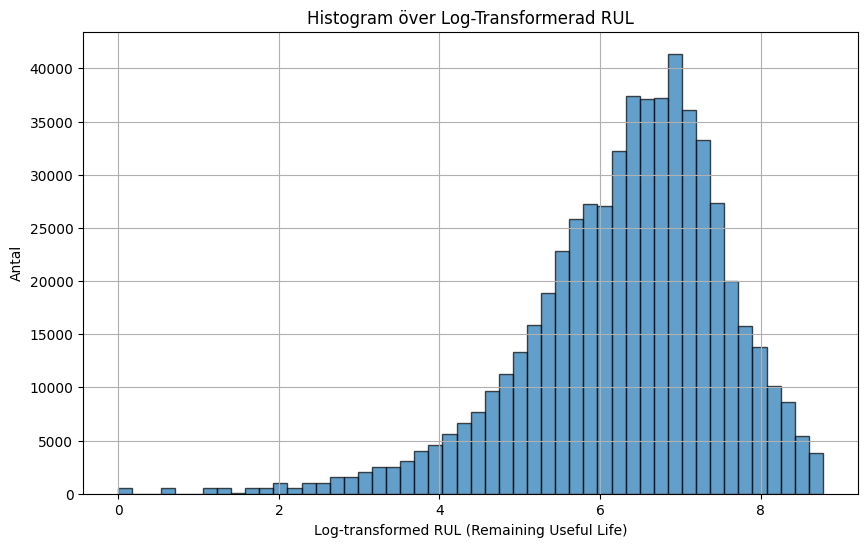

In [16]:
# Visualize the log-transformed RUL
plt.figure(figsize=(10, 6))
plt.hist(df_train['RUL_log'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram över Log-Transformerad RUL')
plt.xlabel('Log-transformed RUL (Remaining Useful Life)')
plt.ylabel('Antal')
plt.grid(True)
plt.show()




In [17]:
def create_sequences(X, y_rul, time_steps):
    Xs, ys_rul = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys_rul.append(y_rul[i + time_steps])
        
    return np.array(Xs), np.array(ys_rul)


time_steps = 24
X_train_seq, y_train_rul_seq = create_sequences(X_train_np, y_train_rul_log, time_steps)
X_val_seq, y_val_rul_seq = create_sequences(X_val_np, y_val_rul_log, time_steps)
X_test_seq, y_test_rul_seq = create_sequences(X_test_np, y_test_rul_log, time_steps)

#Saving sequences for streamlit app.
#np.save('../data/test_seq_rul_1', X_test_seq[:int(len(X_test_seq)/2)])
#np.save('../data/test_seq_rul_2', X_test_seq[int(len(X_test_seq)/2):])

In [18]:
X_train_seq.shape


(580276, 24, 15)

In [ ]:
input_layer = Input(shape=(time_steps, 15))     
lstm_out = Bidirectional(LSTM(128, activation='tanh', return_sequences=True))(input_layer)
lstm_out = Dropout(0.3)(lstm_out)
lstm_out = Bidirectional(LSTM(64, activation='tanh', return_sequences=True))(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(50, activation='tanh', return_sequences=True)(lstm_out) 

lstm_out = LSTM(50, activation ='tanh', return_sequences=False)(lstm_out) 
lstm_out = Dropout(0.2)(lstm_out)

rul_pred_log = Dense(64, activation='relu')(lstm_out)
when_output = Dense(1, name='RUL_log')(rul_pred_log) 

model = Model(inputs=input_layer, outputs=when_output)


huber_loss = Huber()

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mae'])


checkpoint = ModelCheckpoint('best_lstm_.keras', 
                             monitor='val_loss',  
                             save_best_only=True,  
                             mode='min',  
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8)


history = model.fit(
    X_train_seq,             # 3D array: (samples, time_steps, features)
    y_train_rul_seq,         # 2D array: (samples, 1)
    validation_data=(X_val_seq, y_val_rul_seq),  
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


results = model.evaluate(X_test_seq, y_test_rul_seq)
test_loss, test_rul1_mae = results

print(f"Test Loss for RUL: {test_loss}")
print(f"MAE for RUL: {test_rul1_mae}")




Epoch 1/50
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.7071 - mae: 1.0984
Epoch 1: val_loss improved from inf to 0.38816, saving model to best_lstm_.keras
2267/2267 ━━━━━━━━━━━━━━━━━━━━ 242s 104ms/step - loss: 0.7070 - mae: 1.0983 - val_loss: 0.3882 - val_mae: 0.7401 - learning_rate: 0.0010
Epoch 2/50
  51/2267 ━━━━━━━━━━━━━━━━━━━━ 3:47 103ms/step - loss: 0.3960 - mae: 0.7654

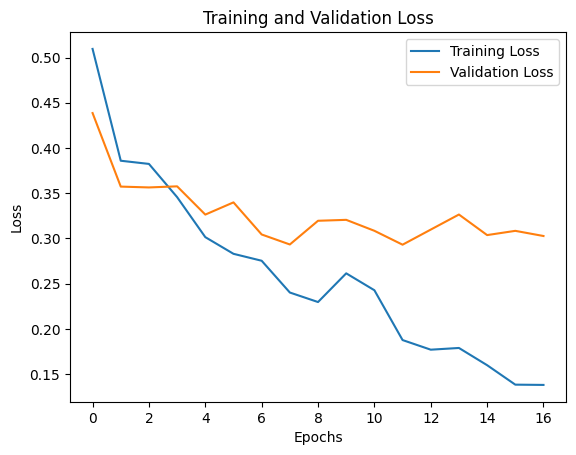

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


4503/4503 ━━━━━━━━━━━━━━━━━━━━ 55s 12ms/step


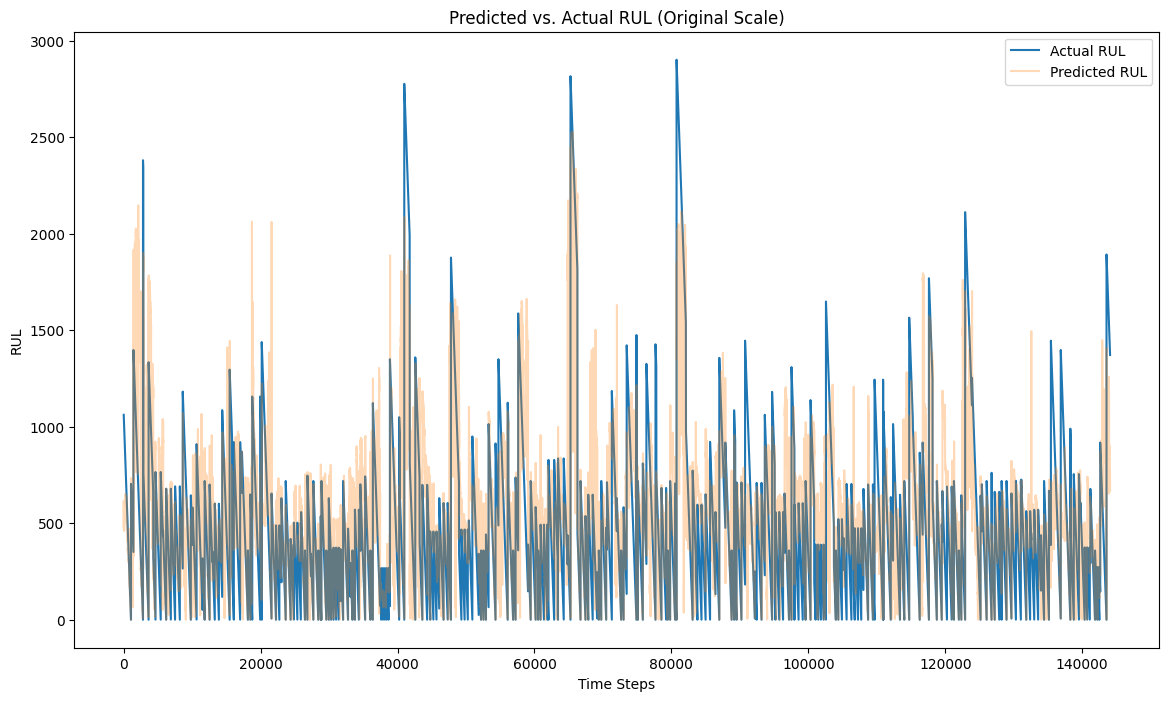

In [ ]:

y_pred_log = model.predict(X_test_seq)


y_pred_rul = np.expm1(y_pred_log)

plt.figure(figsize=(14, 8))
plt.plot(np.expm1(y_test_rul_seq), label='Actual RUL')
plt.plot(y_pred_rul, label='Predicted RUL', alpha=0.3)
plt.xlabel('Time Steps')
plt.ylabel('RUL')
plt.legend()
plt.title('Predicted vs. Actual RUL (Original Scale)')
plt.show()


rul_comparison_df = pd.DataFrame({
    'Actual RUL': np.expm1(y_test_rul_seq).flatten(),  
    'Predicted RUL': y_pred_rul.flatten()  
})




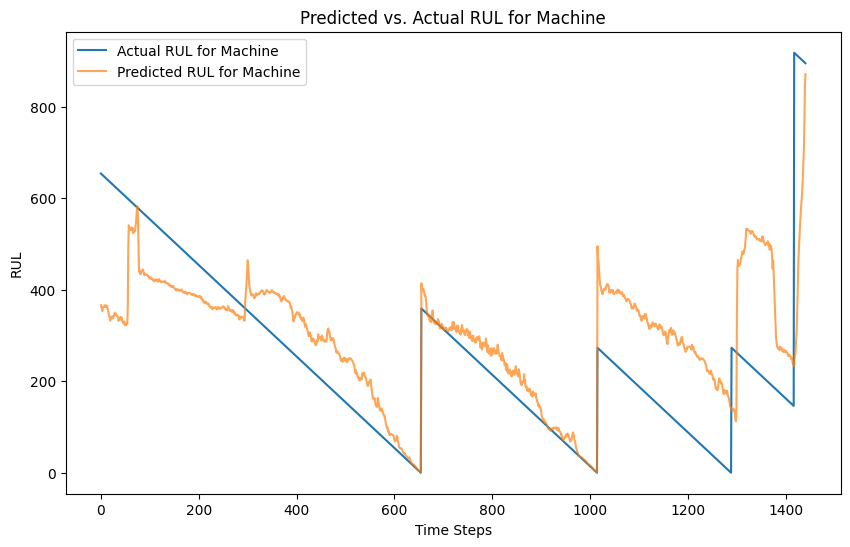

In [ ]:

machine_test_seq = X_test_seq[:, 0, 0]  # pulling out the first feature which is machineID

rul_comparison_df = pd.DataFrame({
    'machineID': machine_test_seq,  
    'Actual RUL': np.expm1(y_test_rul_seq), 
    'Predicted RUL': y_pred_rul.flatten() 
})


machine_pred_actual_df = rul_comparison_df[rul_comparison_df['machineID'] ==99]


plt.figure(figsize=(10, 6))
plt.plot(machine_pred_actual_df['Actual RUL'].values, label='Actual RUL for Machine')
plt.plot(machine_pred_actual_df['Predicted RUL'].values, label='Predicted RUL for Machine', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('RUL')
plt.legend()
plt.title('Predicted vs. Actual RUL for Machine')
plt.show()


In [ ]:

machine_id = 17
X_test_machine = X_test_seq[df_test['machineID'][time_steps:] == machine_id]

# Predict RUL for this machine's sequences
y_pred_rul_log_machine = model.predict(X_test_machine)

# Transform the predicted RUL from log scale back to the original scale
y_pred_rul_machine = np.expm1(y_pred_rul_log_machine)

# Find the last predicted RUL value, which indicates the remaining hours until failure
predicted_rul_hours = y_pred_rul_machine[-1][0]


print(f"The predicted remaining useful life for machine {machine_id} is approximately {predicted_rul_hours:.2f} hours.")


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
The predicted remaining useful life for machine 17 is approximately 270.87 hours.


In [ ]:
df_merged['volt_pressure_interaction'] = (
    df_merged['volt'] * df_merged['pressure'])
df_merged['volt_rotate_interaction'] = (
    df_merged['volt'] * df_merged['rotate'])
df_merged['volt_vibration_interaction'] = (
    df_merged['volt'] * df_merged['vibration'])

df_merged['rotate_pressure_interaction'] = (
    df_merged['rotate'] * df_merged['pressure'])
df_merged['rotate_vibration_interaction'] = (
    df_merged['rotate'] * df_merged['vibration'])

df_merged['pressure_vibration_interaction'] = (
    df_merged['pressure'] * df_merged['vibration'])

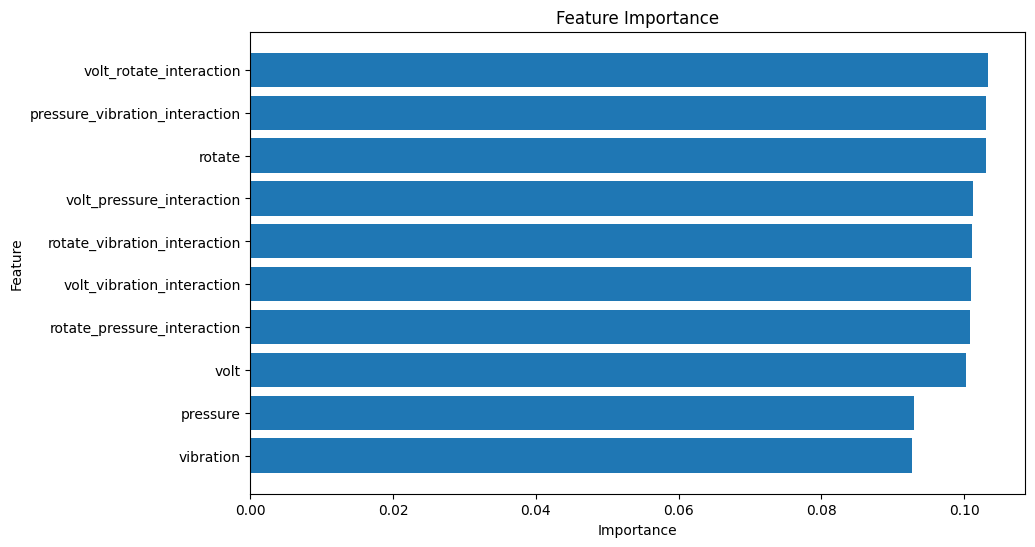

Mean Absolute Error: 676.1129276253636


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


features = ['volt', 'rotate', 'pressure', 'vibration', 
            'volt_rotate_interaction', 'volt_pressure_interaction', 'volt_vibration_interaction', 
            'rotate_pressure_interaction', 'rotate_vibration_interaction', 'pressure_vibration_interaction']
target = 'RUL'

X = df_merged[features]
y = df_merged[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=20, random_state=42)
model.fit(X_train, y_train)

# Calculate feature importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Evaluate the model performance (optional)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

In [ ]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Calculate the correlation matrix again with standardized data
corr_matrix = X_scaled.corr()
print(corr_matrix)




                                    volt    rotate  pressure  vibration  \
volt                            1.000000 -0.001477  0.001675   0.002374   
rotate                         -0.001477  1.000000 -0.000643  -0.003099   
pressure                        0.001675 -0.000643  1.000000   0.001390   
vibration                       0.002374 -0.003099  0.001390   1.000000   
volt_rotate_interaction         0.607848  0.789893  0.000601  -0.000842   
volt_pressure_interaction       0.637485 -0.001346  0.768366   0.002632   
volt_vibration_interaction      0.563728 -0.003209  0.002143   0.823916   
rotate_pressure_interaction     0.000157  0.730404  0.677813  -0.001417   
rotate_vibration_interaction    0.000994  0.659894  0.000506   0.744101   
pressure_vibration_interaction  0.002951 -0.002890  0.634034   0.769594   

                                volt_rotate_interaction  \
volt                                           0.607848   
rotate                                         0.789893 

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Adding a constant column for VIF calculation
X_with_constant = pd.concat([pd.Series(1, index=X.index, name="constant"), X], axis=1)
vif_data = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X_with_constant.values, i + 1) for i in range(len(X.columns))]
})
print(vif_data)



                          Feature         VIF
0                            volt  213.260447
1                          rotate  259.959274
2                        pressure  250.778229
3                       vibration  277.076904
4         volt_rotate_interaction  193.473198
5       volt_pressure_interaction  205.544942
6      volt_vibration_interaction  179.436064
7     rotate_pressure_interaction  155.217796
8    rotate_vibration_interaction  128.190878
9  pressure_vibration_interaction  141.250947


In [ ]:
selected_features = ['volt_rotate_interaction', 'volt_vibration_interaction', 
                     'rotate_pressure_interaction', 'pressure_vibration_interaction']


X = df_merged[selected_features]
y = df_merged['RUL']

